# Prototype Model
This is used to understand the data and all the neccessary preprocessing steps required before the model building process. Using what we learn from this model, we'll build a pipeline that will cover all the prepossicing steps. Typcially you would explore the data and find out what mandatory cleaning needs to be done to quickly build the prototype. Since this project includes multiple datasets, I had a seperate file where I did some general exploration just to answer a few questions and understand the data. I won't do much exploration in this file, but will do the necessary preprocessing. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import TransformedTargetRegressor

import os
os.chdir("/Users/Tosan.Johnson/Personal Projects/Kaggle Projects/Predict Future Sales") # changing working directory
from IPython.core.interactiveshell import InteractiveShell # allows multiple outputs per cell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df_icats = pd.read_csv('data/item_categories.csv')
df_items = pd.read_csv('data/items.csv')
df_sales = pd.read_csv('data/sales_train.csv')
df_shops = pd.read_csv('data/shops.csv')

In [4]:
df_icats.head()
df_items.head()
df_sales.head()
df_shops.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [3]:
# Merging all the useful columns into df_sales (all columns that I want to train the model on)
df_sales = df_sales.merge(df_items[['item_id','item_category_id']], on='item_id', how='left') # merge the item category column over to the sales table

In [9]:
# checking missing rate - none
df_sales.isna().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

In [29]:
# checking the dtype of all cols
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   item_id           int64  
 3   item_price        float64
 4   item_cnt_day      float64
 5   item_category_id  int64  
dtypes: float64(2), int64(4)
memory usage: 156.8 MB


## Preprocessing

In [6]:
# dropping the date variable (not needed for training)
df_sales.drop(columns='date',inplace=True)

In [7]:
# Use Target encoding on the ID variables (avoiding One hot encoding since there are a ton of groups)

X = df_sales.drop(columns='item_price')
y = df_sales['item_price']
target_encoder = TargetEncoder(cols=['item_category_id', 'item_id','shop_id'])
X = target_encoder.fit_transform(X,y)

In [8]:
# Scale the continuous variables and to normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X) # turning it back into a DF and attaching the correspoding column names to it
X.columns = df_sales.drop(columns='item_price').columns

## Model Buidling
We'll use two simple regression models to predict item price:
* Linear Regression 
* Random Forest Regression

In [9]:
# Gloabl Vars
rs = 0 # random seed

In [10]:
# test and train split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=rs)

In [9]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((2348679, 5), (587170, 5), (2348679,), (587170,))

In [11]:
# Linear Regression
model_lr = LinearRegression()
model_lr.fit(train_x, train_y)

# predictions
predict_train = model_lr.predict(train_x)
predict_test = model_lr.predict(test_x)

# Model Performance Metric - RMSE
train_rmse = math.sqrt(mean_squared_error(train_y, predict_train))
test_rmse = math.sqrt(mean_squared_error(test_y, predict_test))

print(f'Linear Regression - training root mean squared error: {train_rmse}')
print(f'Linear Regression - testing root mean squared error: {test_rmse}')

"""
Result - The training error isn't higher than the testing error, so at least we can say there isn't really overfitting. Overall the error is pretty bad so lets
         try a differrent model and see what we get.
"""

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=StandardScaler())

Linear Regression - training root mean squared error: 356.253852265048
Linear Regression - testing root mean squared error: 290.2746340542328


"\nResult - The training error isn't higher than the testing error, so at least we can say there isn't really overfitting. Overall the error is pretty bad so lets\n         try a differrent model and see what we get.\n"

In [12]:
# Random Forest Regressor
model_rfr = RandomForestRegressor(max_depth=5)
model_rfr.fit(train_x, train_y)

# predictions
predict_train = model_rfr.predict(train_x)
predict_test = model_rfr.predict(test_x)

# Model Performance Metric - RMSE
train_rmse = math.sqrt(mean_squared_error(train_y, predict_train))
test_rmse = math.sqrt(mean_squared_error(test_y, predict_test))

print(f'Random Forest Regressor - training root mean squared error: {train_rmse}')
print(f'Random Forest Regressor - testing root mean squared error: {test_rmse}')

"""
Result - I'm surprised the performance didn't increase by much more than the linear regression. It's still high. Benefit of RF is that I can use this to find
         variable importance.
"""

TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=5),
                           transformer=StandardScaler())

Random Forest Regressor - training root mean squared error: 353.7228482236291
Random Forest Regressor - testing root mean squared error: 286.158089879008


"\nResult - I'm surprised the performance didn't increase by much more than the linear regression. It's still high. Benefit of RF is that I can use this to find\n         variable importance.\n"

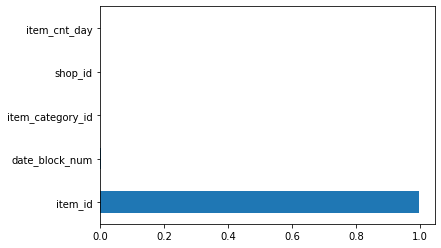

In [26]:
# Feature importance - RF
feature_imp = pd.Series(model_rfr.feature_importances_, index=X.columns)
feature_imp.nlargest(5).plot(kind='barh')

"""
Result - Clearly I'm a moron. It only uses the item_id var, which makes sense. There's no data leakage so its not like I have to drop this variable. I'll just have to make the other variables
         more powerful. I'm shocked the shop_id var isn't contributing at all, as well as the item_category_id. 
"""

In [21]:
# GradientBoostingRegressor
model_xgb = XGBRegressor()
# wrapped_model_xgb = TransformedTargetRegressor(regressor=model_xgb, transformer=StandardScaler())
model_xgb.fit(train_x, train_y)

# predictions
predict_train = model_xgb.predict(train_x)
predict_test = model_xgb.predict(test_x)

# Model Performance Metric - RMSE
train_rmse = math.sqrt(mean_squared_error(train_y, predict_train))
test_rmse = math.sqrt(mean_squared_error(test_y, predict_test))

print(f'XGBoost Regressor - training root mean squared error: {train_rmse}')
print(f'XGBoost Regressor - testing root mean squared error: {test_rmse}')

"""
Result - As expected, XGBoost blows every other model out of the water. Even without Paramater tuning. This will mostl likely be our model of chocie but at
         least we have an initial sense of performance, and what variables are important. 
"""

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

XGBoost Regressor - training root mean squared error: 242.77336668244936
XGBoost Regressor - testing root mean squared error: 211.75418190490706


'\nResult - As expected, XGBoost blows every other model out of the water. Even without Paramater tuning. This will mostl likely be our model of chocie but at\n         least we have an initial sense of performance, and what variables are important.\n'

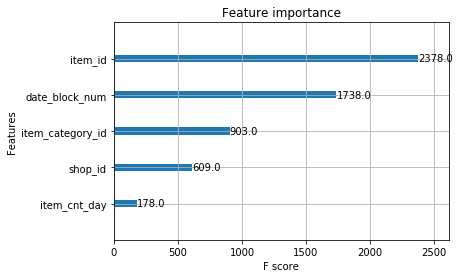

In [22]:
plot_importance(model_xgb)
plt.show()
"""
Result - Looking at the feature importance we can see that there the model is using pretty much all of the variables (unlike the RF). The date_block_num
         being number 2 is interesting. There must be some relationship between price and time. Do stores charge more over time? I'm surprised
         item_category_id is 3rd. I guess it gets what it needs from the item_id var.
"""